In [1]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
#mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/Volumes/rhino/home1/dscho/code/general')
import data_io as dio
import array_operations as aop

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

In [171]:
def rmse(v1, v2):
    """Return the root mean squared error
    between equal-length vectors v1 and v2.
    """
    err = v1 - v2
    return np.sqrt(np.dot(err, err)/len(v1))

In [243]:
# Generate pseudo alignment vectors
behav_syncs = 1 + np.arange(100)
eeg_syncs = 1 + np.arange(100)

# Add some random noise.
behav_syncs_ = behav_syncs + np.random.rand(100) - np.random.rand(100)
eeg_syncs_ = eeg_syncs + np.random.rand(100) - np.random.rand(100)

# Randomly remove and add some indices to eeg_syncs
n_remove = 10
n_add = 20
remove_inds = np.arange(len(eeg_syncs))
np.random.shuffle(remove_inds)
eeg_syncs_ = np.delete(eeg_syncs_, remove_inds[:n_remove])
eeg_syncs_ = np.sort(np.concatenate((eeg_syncs_, np.random.rand(n_add) * 100)))

# For each behavioral sync time, find the closest EEG time
ttl_pairs = np.array([(behav_syncs_[i], eeg_syncs_[np.abs(eeg_syncs_ - behav_syncs_[i]).argmin()]) 
                      for i in range(len(behav_syncs_))])

# Get a robust linear fit between the sync vectors.
X = sm.add_constant(ttl_pairs[:, 0]) # the behavioral times
y = ttl_pairs[:, 1] # the EEG channel times
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
intercept, slope = rlm_results.params

# Fit behavioral to EEG sync times and calculate the RMSE
behav_syncs_aligned = intercept + (slope * behav_syncs)
print('RMSE: {:.4f}'.format(rmse(behav_syncs_aligned, eeg_syncs)))

RMSE: 0.0168


Text(0,0.5,'EEG sync times')

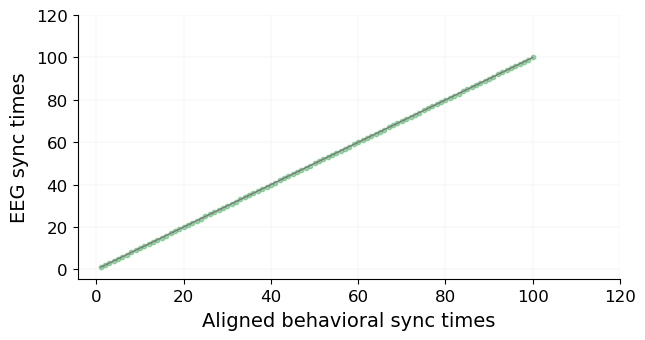

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), dpi=100)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14

i = 0
xpred = np.linspace(np.min(behav_syncs), np.max(behav_syncs), 100)
ypred = intercept + (slope * xpred)
ax[i].plot(xpred, ypred, color=colors[5], linewidth=1)
# ax[i].scatter(ttl_pairs[:, 0], ttl_pairs[:, 1], alpha=0.5, s=10, color=colors[0])
ax[i].scatter(behav_syncs, eeg_syncs, alpha=0.5, s=10, color=colors[2])
ax[i].set_xticks(np.arange(121)[::20])
ax[i].set_yticks(np.arange(121)[::20])
ax[i].set_xticklabels(np.arange(121)[::20], fontsize=tickfontsize)
ax[i].set_yticklabels(np.arange(121)[::20], fontsize=tickfontsize)
ax[i].set_xlabel('Aligned behavioral sync times', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('EEG sync times', fontsize=labelfontsize, labelpad=5)